In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import nltk

In [15]:
import spacy

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [6]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools

In [7]:
import text_cleaning_functions as clean

In [8]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [9]:
RANDOM_STATE = 2

In [10]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [11]:
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()

In [12]:
train['text_clean'] = train['text'].apply(lambda x: clean.remove_URL(x))
train['text_clean'] = train['text_clean'].apply(lambda x: clean.remove_emoji(x))
train['text_clean'] = train['text_clean'].apply(lambda x: clean.remove_html(x))
train['text_clean'] = train['text_clean'].apply(lambda x: clean.remove_punctuation(x))
train['text_clean'] = train['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [13]:
test['text_clean'] = test['text'].apply(lambda x: clean.remove_URL(x))
test['text_clean'] = test['text_clean'].apply(lambda x: clean.remove_emoji(x))
test['text_clean'] = test['text_clean'].apply(lambda x: clean.remove_html(x))
test['text_clean'] = test['text_clean'].apply(lambda x: clean.remove_punctuation(x))
test['text_clean'] = test['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [16]:
nlp = spacy.load('en_core_web_sm')

In [17]:
train['text_lemma'] = train["text_clean"].apply(lambda row: " ".join([w.lemma_ for w in nlp(row)]))
test['text_lemma'] = test["text_clean"].apply(lambda row: " ".join([w.lemma_ for w in nlp(row)]))

In [18]:
train.head()

,id,keyword,location,text,target,text_clean,text_lemma
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,deeds reason earthquake may allah forgive us,deed reason earthquake may allah forgive we
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,got send photo ruby alaska smoke wildfire pour...


In [19]:
test.head()

,id,keyword,location,text,text_clean,text_lemma
0,0,NaN,NaN,just happened a terrible car crash,happened terrible car crash,happen terrible car crash
1,2,NaN,NaN,"heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...,hear earthquake different city stay safe everyone
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires,apocalypse lighting spokane wildfires,apocalypse light spokane wildfire
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,typhoon soudelor kills 28 china taiwan,typhoon soudelor kill 28 china taiwan


In [20]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [21]:
embeddings_dictionary['earthquake']

array([-0.093032 ,  1.6301   ,  0.36645  ,  0.29015  , -0.81781  ,
       -0.46611  ,  0.037282 ,  0.13208  ,  0.13661  ,  1.2091   ,
        0.81466  , -0.12874  ,  0.52387  , -0.024319 ,  0.94072  ,
       -0.12509  , -0.34087  ,  0.19321  , -1.0522   ,  0.62915  ,
       -0.0699   ,  0.14182  ,  0.49985  ,  0.61688  ,  0.027162 ,
        0.22695  , -0.89086  ,  1.4411   , -0.45774  , -0.5922   ,
        0.48147  , -0.4387   ,  0.99552  ,  1.3003   , -1.1123   ,
       -1.4847   ,  0.53476  , -0.22524  , -0.21366  , -0.14612  ,
       -0.50853  ,  0.82284  , -0.075167 , -0.60331  ,  0.86412  ,
        0.15815  ,  0.76075  , -0.28173  ,  0.27679  , -0.43729  ,
       -0.53438  ,  0.081051 ,  0.98763  , -0.28154  , -0.15944  ,
       -1.9562   ,  0.13058  , -0.46506  ,  1.4629   ,  1.262    ,
       -0.46154  ,  1.3625   , -0.40815  , -0.24256  ,  0.21117  ,
        0.57007  , -1.6566   , -0.21043  ,  0.97449  , -0.16146  ,
       -0.33706  ,  0.50539  ,  0.45718  ,  0.2184   ,  0.6955

In [22]:
train_1 = train.text_lemma.values
test_1 = test.text_lemma.values
sentiments = train.target.values

In [23]:
sentiments

array([1, 1, 1, ..., 1, 1, 1])

In [24]:
from collections import Counter

In [25]:
Counter(sentiments)

Counter({1: 3271, 0: 4342})

In [26]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_1)
vocab_length = len(word_tokenizer.word_index) + 1

In [27]:
longest_train = max(train_1, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(train_1), length_long_sentence, padding='post')
test_sentences = pad_sequences(embed(test_1), length_long_sentence, padding='post')

In [28]:
length_long_sentence

24

In [29]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [30]:
X_train, X_test, y_train, y_test = train_test_split(padded_sentences, sentiments, 
                                                    test_size=0.2, random_state = RANDOM_STATE)

In [31]:
X_train.shape

(6090, 24)

In [32]:
X_test.shape

(1523, 24)

In [33]:
y_train.shape

(6090,)

In [34]:
y_test.shape

(1523,)

In [44]:
BATCH_SIZE = 16
EPOCHS = 2

In [45]:
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                    output_dim=embedding_matrix.shape[1], 
                    weights = [embedding_matrix], 
                    input_length=length_long_sentence))
model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(length_long_sentence, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 100)           1571000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 24, 48)            24000     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 48)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                1176      
_________________________________________________________________
dropout_2 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 1,596,201
Trainable params: 1,596,201
Non-trainable params: 0
____________________________________________

In [47]:
history = model.fit(X_train, 
                    y_train, 
                    epochs = EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    validation_data = (X_test, y_test), 
                    verbose = 1)

Epoch 1/2
381/381 [==============================] - 13s 26ms/step - loss: 0.5634 - accuracy: 0.7270 - val_loss: 0.4203 - val_accuracy: 0.8194
Epoch 2/2
381/381 [==============================] - 10s 26ms/step - loss: 0.3734 - accuracy: 0.8419 - val_loss: 0.4102 - val_accuracy: 0.8240


In [48]:
final_loss, final_acc = model.evaluate(X_test, y_test, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.410224, final accuracy: 0.824032


In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [50]:
# Predict the values from the validation dataset
y_pred = model.predict_classes(X_test)

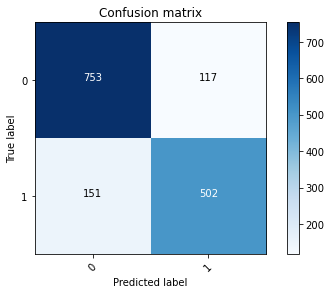

In [51]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [53]:
print(history.history.keys())
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


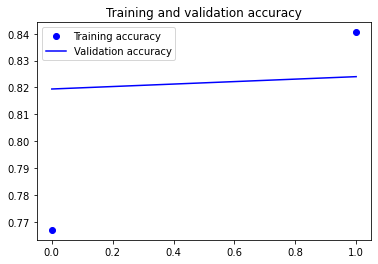

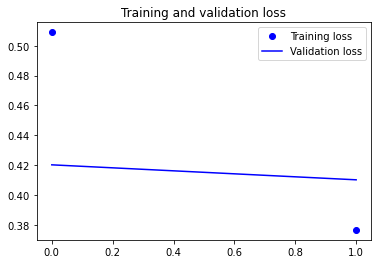

In [54]:
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [55]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))

In [56]:
metrics(y_pred, y_test)

F1-score:  0.789308176100629
Precision:  0.7687595712098009
Recall:  0.8109854604200323
Acuracy:  0.8240315167432699
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       904
           1       0.77      0.81      0.79       619

    accuracy                           0.82      1523
   macro avg       0.82      0.82      0.82      1523
weighted avg       0.83      0.82      0.82      1523



In [57]:
test.head()

,id,keyword,location,text,text_clean,text_lemma
0,0,NaN,NaN,just happened a terrible car crash,happened terrible car crash,happen terrible car crash
1,2,NaN,NaN,"heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...,hear earthquake different city stay safe everyone
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires,apocalypse lighting spokane wildfires,apocalypse light spokane wildfire
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,typhoon soudelor kills 28 china taiwan,typhoon soudelor kill 28 china taiwan


In [58]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = model.predict_classes(test_sentences)

In [59]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [60]:
submission.to_csv("basic_lstm_lemma.csv", index=False)